Always try to simplify the data given in neural network !!!

So the input is going to be images pf cats and dogs but the images are going to be in various size and shapes so first thing we do is resize them to uniform size so that we can feed to the CNN, so you have many options with m=images you can rezise,pad, crop, flip, rotate etc

Converting an input image to grayscale before feeding it into a Convolutional Neural Network (CNN) is a common preprocessing step done for two main reasons: to **reduce complexity** and to **focus on essential features** when color isn't important.

---
### Reducing Computational Complexity ⚙️
The biggest advantage of using grayscale images is that it makes the CNN model simpler and faster to train.

* **Fewer Parameters:** A color image has three channels (Red, Green, Blue - RGB), while a grayscale image has only one channel representing intensity (shades of gray).
* **Faster Training:** With only one channel to process instead of three, the number of calculations the network has to perform at each layer is significantly reduced. This means the model will train faster and require less memory and computational power.



---
### Focusing on Relevant Features
For many computer vision tasks, the color of an object is irrelevant and can even be considered "noise" that distracts the model. By converting to grayscale, you force the CNN to learn from more fundamental features like **shape, texture, and edges**.

* **Good Use Cases:**
    * **Character Recognition (OCR):** The shape of a letter is what matters, not its color.
    * **Medical Imaging:** In many X-rays or MRI scans, the important information is in the contrast and structure, not color.
    * **Some Object Detection:** For identifying the shape of a car or a pedestrian, the outline and texture are often more critical than the specific color.

---
### When Not to Use Grayscale
It's important to remember that this technique is not suitable for every problem. You should **avoid converting to grayscale** when color is a critical feature for classification.

* **Bad Use Cases:**
    * **Fruit Ripeness Detection:** Distinguishing between a green (unripe) and a red (ripe) apple requires color information.
    * **Traffic Light Recognition:** The model must be able to differentiate between red, yellow, and green lights.
    * **Flower Species Classification:** The color of the petals is often a key identifier for different types of flowers.

In summary, the decision to use grayscale is a strategic choice. If color doesn't add valuable information for your specific problem, converting to grayscale is an effective way to simplify your model, speed up training, and potentially reduce overfitting.

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm

REBUILD_DATA = False #Keep True only when make_training_data() to be called

# data source https://www.microsoft.com/en-us/download/details.aspx?id=54765

class DogsVSCats():
  IMG_SIZE = 50
  CATS = "drive/MyDrive/kagglecatsanddogs_5340/PetImages/Cat"
  DOGS = "drive/MyDrive/kagglecatsanddogs_5340/PetImages/Dog"
  LABELS = {CATS: 0, DOGS: 1}
  training_data = []
  catcount = 0 #here we have count to check if have class imbalance
  dogcount = 0

  def make_training_data(self):
    for label in self.LABELS:
      print(label)
      for f in tqdm(os.listdir(label)):
        if "jpg" in f:
          try:
            img = cv2.imread(os.path.join(label,f), cv2.IMREAD_GRAYSCALE)
            if img is not None:  # Check if image loaded successfully
              img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
              self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) #n.eye gives array where there are 1s in diagonal and everythings else is 0, you can use it for creating one hot vectors

              if label == self.CATS:
                self.catcount += 1
              elif label == self.DOGS:
                self.dogcount += 1
          except Exception as e: #some of images are not good so
            print(f"Error processing {f}: {e}")
            pass

    # Move shuffle and save outside the loop - should only happen once after all data is collected
    np.random.shuffle(self.training_data)

    # Convert to numpy arrays with proper structure
    X = np.array([item[0] for item in self.training_data])
    y = np.array([item[1] for item in self.training_data])

    # Save as separate arrays or as a dictionary
    # np.save("training_idata.npy", self.training_data, allow_pickle=True)
    np.save("training_images.npy", X)
    np.save("training_labels.npy", y)

    print("Cats:", self.catcount)
    print("Dogs:", self.dogcount)
    print(f"Total training samples: {len(self.training_data)}")
    print(f"Image shape: {X.shape}")
    print(f"Labels shape: {y.shape}")

if REBUILD_DATA:
  dogsvcats = DogsVSCats()
  dogsvcats.make_training_data()

# Load the training data
# X = np.load("training_images.npy")
# y = np.load("training_labels.npy")
# print(f"Loaded {len(X)} training samples")
# print(f"Image shape: {X.shape}")
# print(f"Labels shape: {y.shape}")

In [3]:
training_data_i = np.load("training_images.npy", allow_pickle=True)
training_data_l = np.load("training_labels.npy", allow_pickle=True)

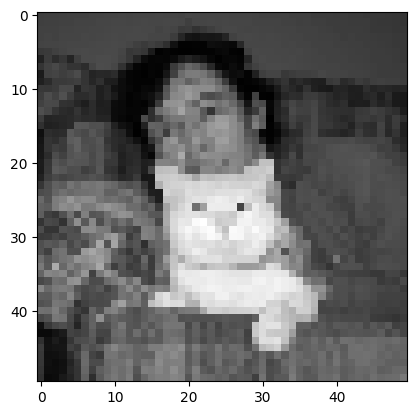

In [4]:
import matplotlib.pyplot as plt

plt.imshow(training_data_i[0], cmap="gray")
plt.show()

In [5]:
training_data_l[0]

array([0., 1.])

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 5) # number of input channel is 1, number of output is 32, 5 is kernel size (the filter window in convolution)
    self.conv2 = nn.Conv2d(32, 64, 5) # the output of above here is input to this one they should match
    self.conv3 = nn.Conv2d(64, 128, 5) # at this point you need to have one to two linear CN , these convolutions could come one after another in NN

    x = torch.rand(50,50).view(-1,1,50,50)
    self._to_linear = None
    self.convs(x) #here we are passing randon datapoint to the forward pass to figure out the input numbers required for linear function, see the explaination below

    # self.x = nn.Linear(128*2*2, 512) # this came by running the above and printing (x[0].shape) which comes as [128, 2, 2] search for I'm here
    # self.y = nn.Linear(512, 2)

    self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
    self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes (dog vs cat).

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))

    # print(x[0].shape) #I'm here

    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2] #this is dimention of the linear output we want
    return x

  def forward(self, x):
    x = self.convs(x) # here all the convolutions we pass, basically forward pass
    x= x.view(-1, self._to_linear) # then we flatten it with view
    x = F.relu(self.fc1(x)) # again fully connected then reLU
    x= self.fc2(x)   # again fully connected
    return F.softmax(x, dim=1) #dim is for batches, dim=0 → across batches (4 samples) # dim=1 → across classes (3 categories per sample)

net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


## **What are Channels?**

**Channels** represent different "layers" or "features" of your data:

1. **Input Channels**:
   - For grayscale images: 1 channel (just intensity values)
   - For RGB color images: 3 channels (Red, Green, Blue)
   - For other data: could be different feature maps

2. **Output Channels**:
   - These are the number of different feature detectors/filters the convolutional layer learns
   - Each output channel learns to detect different patterns (edges, textures, shapes, etc.)

In your code:
```python
self.conv1 = nn.Conv2d(1, 32, 5)    # 1 input channel → 32 output channels
self.conv2 = nn.Conv2d(32, 64, 5)   # 32 input channels → 64 output channels  
self.conv3 = nn.Conv2d(64, 128, 5)  # 64 input channels → 128 output channels
```

## **Why Do You Need Linear Layers?**

**Linear layers** (fully connected layers) are needed because:

1. **Convolutional layers** extract spatial features but maintain spatial structure
2. **Linear layers** make the final classification decision by combining all features
3. You need to **flatten** the 2D feature maps into a 1D vector before feeding to linear layers

## **How Input/Output Dimensions Are Determined**

Your clever approach calculates dimensions dynamically:

```python
x = torch.rand(50,50).view(-1,1,50,50)  # Create dummy input: [batch, channels, height, width]
self._to_linear = None
self.convs(x)  # Pass through conv layers to see output size
```

**The dimension calculation process:**

1. **Input**: `[batch, 1, 50, 50]` (grayscale 50×50 images)

2. **After conv1 + maxpool**: `[batch, 32, 23, 23]`
   - Conv reduces: 50 - 5 + 1 = 46
   - Maxpool reduces: 46 / 2 = 23

3. **After conv2 + maxpool**: `[batch, 64, 9, 9]`
   - Conv reduces: 23 - 5 + 1 = 19  
   - Maxpool reduces: 19 / 2 = 9 (rounded down)

4. **After conv3 + maxpool**: `[batch, 128, 2, 2]`
   - Conv reduces: 9 - 5 + 1 = 5
   - Maxpool reduces: 5 / 2 = 2 (rounded down)

5. **Flattening**: 128 × 2 × 2 = 512 features

That's why you have:
```python
self.x = nn.Linear(128*2*2, 512)  # 512 input features → 512 hidden units
self.y = nn.Linear(512, 2)        # 512 hidden units → 2 output classes
```


In [31]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.0001)
loss_function = nn.MSELoss() #Mean Squared Error

training_data_i = np.load("training_images.npy", allow_pickle=True)
training_data_l = np.load("training_labels.npy", allow_pickle=True)

X = torch.Tensor(training_data_i).view(-1, 50, 50) #flatten array
X= X/255.0 # scaling the imagary, as input is between o to 255 here we are makaing it between 0 to 255
y= torch.Tensor(training_data_l)

VAL_PCT = 0.1 # training, testing, validation data separation. valaidation percentage
Val_size = int(len(X)*VAL_PCT)
print(Val_size)


2502


In [32]:
train_X = X[:-Val_size]
train_y = y[:-Val_size]

test_X = X[-Val_size:]
test_y = y[-Val_size:]

print(f"train size: {len(train_X)}")
print(f"test size: {len(test_X)}")

train size: 22520
test size: 2502


In [33]:
BATCH_SIZE = 100 #If you are hitting memory you can definitely try batch size, if the batch size less than 8 doesn't work the start twiking model itself
EPOCHS = 5

for epoch in range(EPOCHS):
  for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
    #print(i)
    #print(i+BATCH_SIZE)
    batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50) #view flattens
    batch_y = train_y[i:i+BATCH_SIZE]

    net.zero_grad #reset the gradients of the model's parameters to zero. This is a crucial step before calculating gradients for the current batch of data during the training process.
    outputs = net(batch_X)
    loss = loss_function(outputs, batch_y)
    loss.backward()
    optimizer.step()
  print(f"Epoch: {epoch}. Loss: {loss}") # If loss decreasing per epoch then we are learning something

print(loss)



100%|██████████| 226/226 [01:48<00:00,  2.09it/s]

tensor(0.5230, grad_fn=<MseLossBackward0>)


In [30]:
correct = 0
total = 0
with torch.no_grad(): # you can use eval and train from model as well
  for i in tqdm(range(len(test_X))):
    real_class = torch.argmax(test_y[i])
    net_out = net(test_X[i].view(-1, 1, 50, 50))[0]
    predicted_class = torch.argmax(net_out)

    if predicted_class == real_class:
      correct += 1
    total += 1
print(correct)
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2502/2502 [00:05<00:00, 452.17it/s]

1270
Accuracy:  0.508


the accuracy is 50.8% how can I improve further


Improving model accuracy can involve several strategies. Here's a plan to explore some common techniques:

* Increase epochs: Train the model for more epochs to allow it more time to learn from the data. (I changed from 1 to 5 but it did not affect accuracy)
* Adjust learning rate: Experiment with a different learning rate for the optimizer. A smaller learning rate might lead to better convergence, while a larger one could speed up training but risk overshooting the minimum.(tried with 0.001, 0.01 then now 0.0001 not changed  0.508)
* Modify model architecture:
Add more layers (convolutional or linear) to potentially capture more complex features.
Change the kernel size or number of filters in the convolutional layers.
Add dropout layers to reduce overfitting.
* Change loss function: While MSELoss can work for classification, using a loss function more suited for classification like Cross-Entropy Loss is generally recommended.
* Data augmentation: Implement data augmentation techniques (e.g., random flips, rotations, zooms) to increase the size and variability of the training data, which can improve generalization.
* Batch size tuning: Experiment with different batch sizes.
* Check data preprocessing: Revisit the data loading and preprocessing steps to ensure they are optimal.
* Regularization: Add L1 or L2 regularization to the model to prevent overfitting.
* Advanced optimization: Consider using more advanced optimizers like AdamW or RMSprop.
* Transfer learning: For image tasks, using a pre-trained model on a large dataset like ImageNet and fine-tuning it on your specific task can significantly boost performance.
* Finish task: Summarize the improvements made and the final accuracy achieved.



what is Regularization:


Add L1 or L2 regularization to the model to prevent overfitting.
L1 and L2 regularization are techniques used in machine learning to prevent overfitting. Here's a breakdown:

* Overfitting: This happens when a model learns the training data too well, including the noise and outliers. As a result, the model performs poorly on new, unseen data.
* Regularization: These techniques add a penalty to the loss function based on the magnitude of the model's weights. This encourages the model to use smaller weights, which generally leads to simpler models that are less prone to overfitting.
Here's how L1 and L2 regularization differ:

* L1 Regularization (Lasso Regression): Adds a penalty proportional to the absolute value of the weights ($\sum |w|$$\sum |w|$). This can lead to some weights becoming exactly zero, effectively performing feature selection.
* L2 Regularization (Ridge Regression): Adds a penalty proportional to the square of the weights ($\sum w^2$$\sum w^2$). This encourages weights to be small but rarely exactly zero. It tends to shrink all weights proportionally.
In the context of your neural network, adding L1 or L2 regularization would involve modifying the loss function to include a term that penalizes large weights in the convolutional and linear layers. This would help prevent the network from becoming too complex and overfitting to the training data.

In [7]:
np.eye(10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [ ]:
np.eye(10)[7]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])